In [11]:
!pip install torch torchvision matplotlib numpy pillow tensorflow scipy opencv-python scikit-learn seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (89 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl (11.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]m3/4 [seaborn]


In [5]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torchvision




In [6]:
train_path = 'data/train'
test_path = 'data/test'
val_path = 'data/val'

#understand the data distribution
# Each path has 2 directories: NORMAL and PNEUMONIA
train_normal_path = os.path.join(train_path, 'NORMAL')
train_pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
test_normal_path = os.path.join(test_path, 'NORMAL')
test_pneumonia_path = os.path.join(test_path, 'PNEUMONIA')
val_normal_path = os.path.join(val_path, 'NORMAL')
val_pneumonia_path = os.path.join(val_path, 'PNEUMONIA')

# Count images in each category
train_normal_count = len(os.listdir(train_normal_path))
train_pneumonia_count = len(os.listdir(train_pneumonia_path))
test_normal_count = len(os.listdir(test_normal_path))
test_pneumonia_count = len(os.listdir(test_pneumonia_path))
val_normal_count = len(os.listdir(val_normal_path))
val_pneumonia_count = len(os.listdir(val_pneumonia_path))

# Count pneumonia by type (virus or bacteria)
train_pneumonia_files = os.listdir(train_pneumonia_path)
train_virus_count = sum(1 for f in train_pneumonia_files if 'virus' in f.lower())
train_bacteria_count = sum(1 for f in train_pneumonia_files if 'bacteria' in f.lower())

test_pneumonia_files = os.listdir(test_pneumonia_path)
test_virus_count = sum(1 for f in test_pneumonia_files if 'virus' in f.lower())
test_bacteria_count = sum(1 for f in test_pneumonia_files if 'bacteria' in f.lower())

val_pneumonia_files = os.listdir(val_pneumonia_path)
val_virus_count = sum(1 for f in val_pneumonia_files if 'virus' in f.lower())
val_bacteria_count = sum(1 for f in val_pneumonia_files if 'bacteria' in f.lower())

# Print label distribution
print(f"Training set   - NORMAL: {train_normal_count}, PNEUMONIA: {train_pneumonia_count} (Virus: {train_virus_count}, Bacteria: {train_bacteria_count})")
print(f"Testing set    - NORMAL: {test_normal_count}, PNEUMONIA: {test_pneumonia_count} (Virus: {test_virus_count}, Bacteria: {test_bacteria_count})")
print(f"Validation set - NORMAL: {val_normal_count}, PNEUMONIA: {val_pneumonia_count} (Virus: {val_virus_count}, Bacteria: {val_bacteria_count})")


Training set   - NORMAL: 1341, PNEUMONIA: 3875 (Virus: 1345, Bacteria: 2530)
Testing set    - NORMAL: 234, PNEUMONIA: 390 (Virus: 148, Bacteria: 242)
Validation set - NORMAL: 8, PNEUMONIA: 8 (Virus: 0, Bacteria: 8)


## Preprocessing


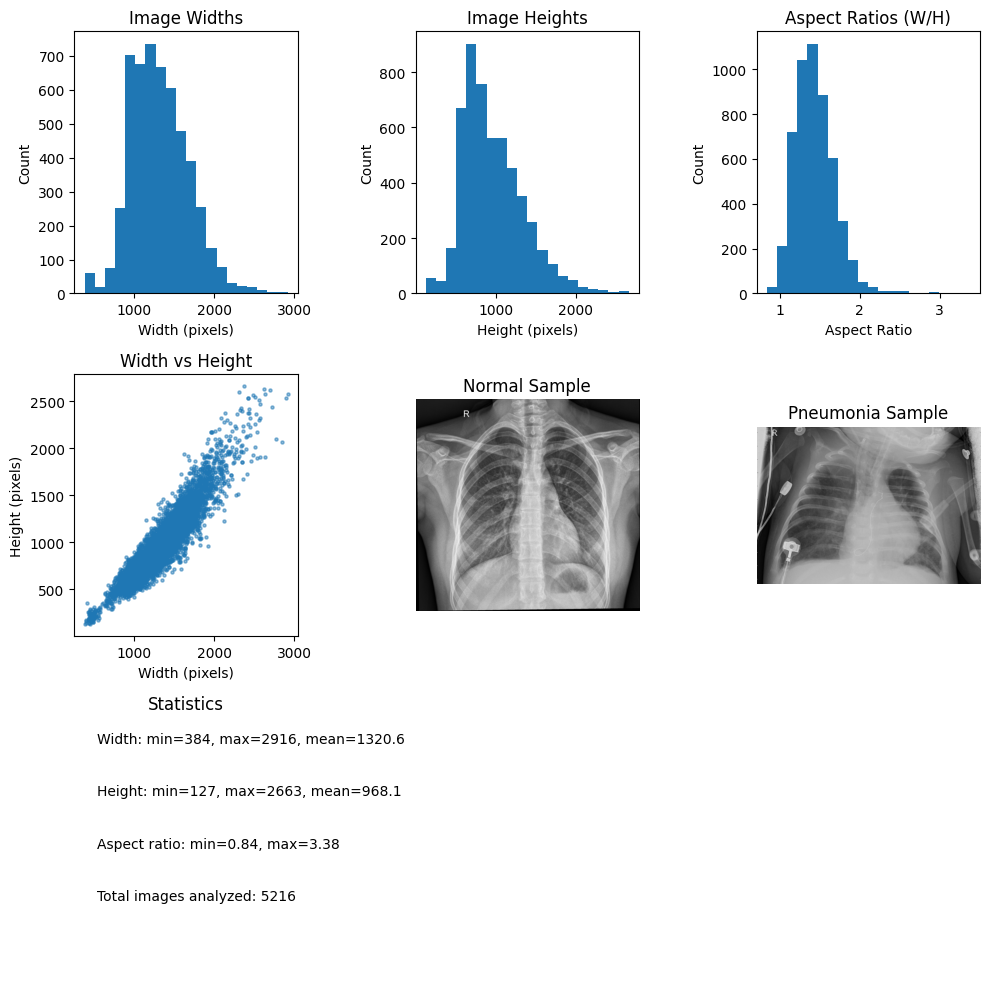

Image size analysis complete.
Average dimensions: 1320.6 x 968.1 pixels
Dimension range: Width 384-2916, Height 127-2663
Average aspect ratio: 1.440


In [7]:
# Analyze image size and proportion distribution
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to analyze images in a directory
def analyze_images(directory):
    sizes = []
    aspect_ratios = []
    
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for img_file in os.listdir(category_path):
                img_path = os.path.join(category_path, img_file)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        height, width = img.shape[:2]
                        sizes.append((width, height))
                        aspect_ratios.append(width / height)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    return sizes, aspect_ratios

# Analyze images in training set
train_sizes, train_aspect_ratios = analyze_images(train_path)

# Create histograms and visualizations
plt.figure(figsize=(10, 10))

# Plot image widths
plt.subplot(3, 3, 1)
plt.hist([w for w, h in train_sizes], bins=20)
plt.title('Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

# Plot image heights
plt.subplot(3, 3, 2)
plt.hist([h for w, h in train_sizes], bins=20)
plt.title('Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

# Plot aspect ratios
plt.subplot(3, 3, 3)
plt.hist(train_aspect_ratios, bins=20)
plt.title('Aspect Ratios (W/H)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')

# Scatter plot of width vs height
plt.subplot(3, 3, 4)
plt.scatter([w for w, h in train_sizes], [h for w, h in train_sizes], alpha=0.5, s=5)
plt.title('Width vs Height')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

# Plot some sample images
plt.subplot(3, 3, 5)
normal_sample = os.path.join(train_normal_path, os.listdir(train_normal_path)[0])
img = cv2.imread(normal_sample)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Normal Sample')
plt.axis('off')

plt.subplot(3, 3, 6)
pneumonia_sample = os.path.join(train_pneumonia_path, os.listdir(train_pneumonia_path)[0])
img = cv2.imread(pneumonia_sample)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Pneumonia Sample')
plt.axis('off')

# Calculate and print statistics
widths = [w for w, h in train_sizes]
heights = [h for w, h in train_sizes]

plt.subplot(3, 3, 7)
plt.text(0.1, 0.9, f"Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}", fontsize=10)
plt.text(0.1, 0.7, f"Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}", fontsize=10)
plt.text(0.1, 0.5, f"Aspect ratio: min={min(train_aspect_ratios):.2f}, max={max(train_aspect_ratios):.2f}", fontsize=10)
plt.text(0.1, 0.3, f"Total images analyzed: {len(train_sizes)}", fontsize=10)
plt.axis('off')
plt.title('Statistics')

plt.tight_layout()
plt.show()

print("Image size analysis complete.")
print(f"Average dimensions: {np.mean(widths):.1f} x {np.mean(heights):.1f} pixels")
print(f"Dimension range: Width {min(widths)}-{max(widths)}, Height {min(heights)}-{max(heights)}")
print(f"Average aspect ratio: {np.mean(train_aspect_ratios):.3f}")


# Pad and Resize

Preparing datasets...
Calculating mean and std from training set...
Training set mean: [0.3415205478668213, 0.3415205478668213, 0.3415205478668213]
Training set std: [0.2806776165962219, 0.2806776165962219, 0.2806776165962219]
Training dataset size: 5216
Validation dataset size: 16
Test dataset size: 624


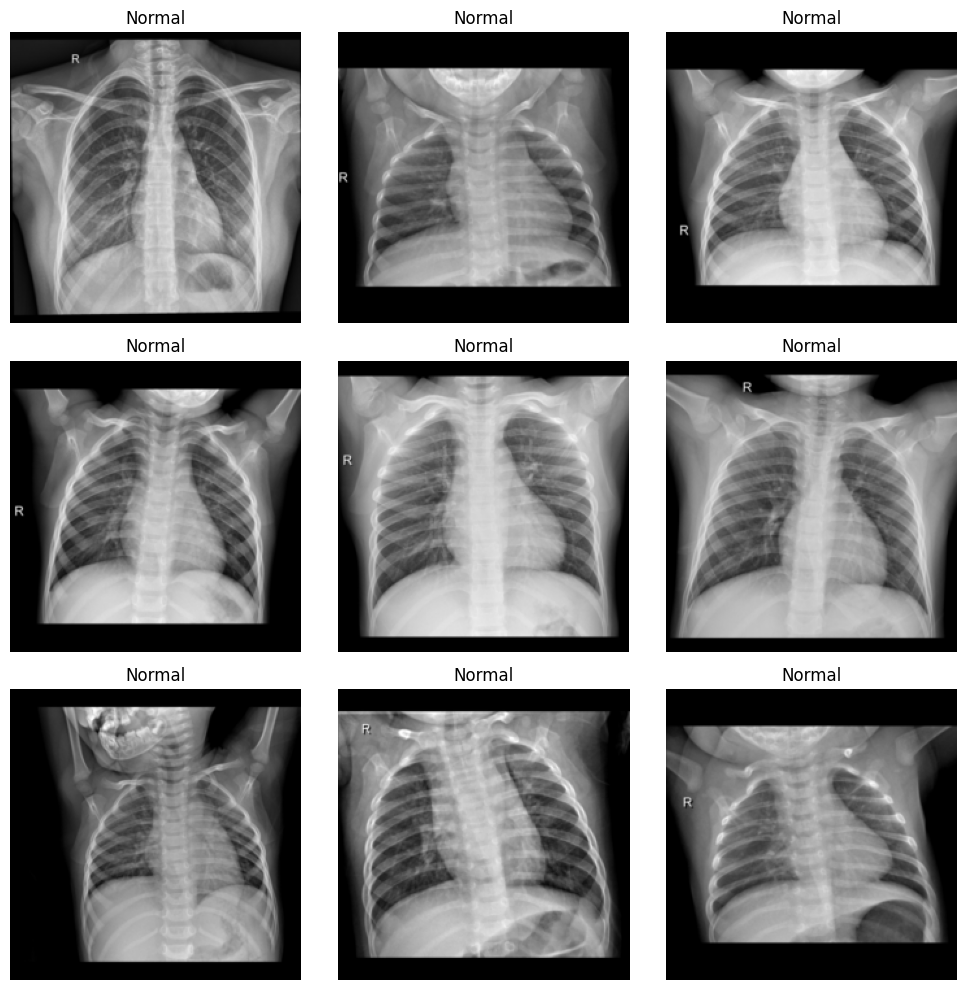

Padded and resized images using PyTorch transforms:
Image shape: torch.Size([3, 224, 224])
Min pixel value: -1.2167716026306152, Max pixel value: 2.0945425033569336


In [18]:
# Define a preprocessing function to pad images to squares before resizing
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os

def pad_to_square(image):
    """Pad the image to make it square with zeros around the border."""
    w, h = image.size
    max_dim = max(w, h)
    pad_w = (max_dim - w) // 2
    pad_h = (max_dim - h) // 2
    padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
    return transforms.functional.pad(image, padding, fill=0)

# Custom dataset class for chest X-ray images
class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, class_dirs, transform=None):
        self.filepaths = []
        self.labels = []
        self.transform = transform
        
        # Define label mapping dictionary
        self.label_map = {'NORMAL': 0, 'PNEUMONIA': 1}
        
        # For each class directory, collect all image paths and assign labels
        for class_dir in class_dirs:
            class_path = os.path.join(root_dir, class_dir)
            files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
            self.filepaths.extend(files)
            self.labels.extend([self.label_map[class_dir]] * len(files))
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# Prepare datasets for training, validation, and testing
print("Preparing datasets...")

# Define paths for datasets
data_dir = 'data'  # Adjust this to your data directory
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Class directories
class_dirs = ['NORMAL', 'PNEUMONIA']

# First, create a temporary dataset with just ToTensor to calculate mean and std
temp_transform = transforms.Compose([
    transforms.Lambda(pad_to_square),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

temp_train_dataset = ChestXRayDataset(
    root_dir=train_dir,
    class_dirs=class_dirs,
    transform=temp_transform
)

# Calculate mean and std from training set only
print("Calculating mean and std from training set...")
mean = torch.zeros(3)
std = torch.zeros(3)

# Use a subset if dataset is large
num_samples = min(len(temp_train_dataset), 1000)
indices = np.random.choice(len(temp_train_dataset), num_samples, replace=False)

for idx in indices:
    img, _ = temp_train_dataset[idx]
    mean += img.mean(dim=(1, 2))
    std += img.std(dim=(1, 2))

mean /= num_samples
std /= num_samples

mean = mean.tolist()
std = std.tolist()

print(f"Training set mean: {mean}")
print(f"Training set std: {std}")

# Now define the final transform with the calculated mean and std
transform = transforms.Compose([
    transforms.Lambda(pad_to_square),               # Pad to square
    transforms.Resize((224, 224)),                  # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),    # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)        # Use training set normalization
])

# Create datasets with the final transform
train_dataset = ChestXRayDataset(
    root_dir=train_dir,
    class_dirs=class_dirs,
    transform=transform
)

val_dataset = ChestXRayDataset(
    root_dir=val_dir,
    class_dirs=class_dirs,
    transform=transform
)

test_dataset = ChestXRayDataset(
    root_dir=test_dir,
    class_dirs=class_dirs,
    transform=transform
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Function to display transformed images
def show_transformed_batch(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(dataset))):
        img, label = dataset[i]
        
        # Convert from tensor to numpy for display
        img = img.permute(1, 2, 0).numpy()
        
        # Denormalize using training set values
        img = std * img + mean
        
        # Clip values to valid range
        img = np.clip(img, 0, 1)
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title('Normal' if label.item() == 0 else 'Pneumonia')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display some transformed images from the training set
show_transformed_batch(train_dataset)

print("Padded and resized images using PyTorch transforms:")
sample_img, _ = train_dataset[0]
print(f"Image shape: {sample_img.shape}")
print(f"Min pixel value: {sample_img.min().item()}, Max pixel value: {sample_img.max().item()}")


## CNN

In [9]:
# Create DataLoaders for CNN with handling class imbalance
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# Calculate class weights to handle imbalance
train_labels = np.array([label for _, label in train_dataset])
class_counts = np.bincount(train_labels)
total_samples = len(train_labels)

# Normalize weights to sum to 1
class_weights = 1. / class_counts
class_weights = class_weights / np.sum(class_weights)  # Normalize to sum to 1

sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

# Create DataLoaders with appropriate batch size and samplers
batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)

# For validation and test sets, we don't use the sampler but keep the original distribution
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Print dataset information
print(f"Class distribution in training set: {class_counts}")
print(f"Class weights applied: {class_weights}")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")


Class distribution in training set: [1341 3875]
Class weights applied: [0.74290644 0.25709356]
Number of batches in train_loader: 163
Number of batches in val_loader: 1
Number of batches in test_loader: 20


In [20]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
import seaborn as sns
import numpy as np

# Define device for training (MPS for Mac M1/M2, GPU if available, otherwise CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the CNN model
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Fourth convolutional block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Fifth convolutional block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x.squeeze()

# Initialize the model
model = PneumoniaCNN().to(device)
print(model)

# Calculate positive weight based on class distribution
pos_weight = torch.tensor([class_counts[0] / class_counts[1]], dtype=torch.float32).to(device)
print(f"Positive weight for loss function: {pos_weight.item()}")

# Define loss functions
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Focal Loss implementation for binary classification
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

# Initialize both loss functions
focal_loss = FocalLoss().to(device)

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Function to find optimal threshold
def find_optimal_threshold(model, val_loader, device):
    model.eval()
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            
            all_outputs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(all_labels, all_outputs)
    
    # Find threshold that maximizes F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    return optimal_threshold

Using device: mps
PneumoniaCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, auc
    import numpy as np
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_aurocs = []
    val_aurocs = []
    train_auprcs = []
    val_auprcs = []
    train_f1s = []
    val_f1s = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_outputs_all = []
        train_labels_all = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store outputs and labels for metrics calculation
            train_outputs_all.extend(torch.sigmoid(outputs).detach().cpu().numpy())
            train_labels_all.extend(labels.cpu().numpy())
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        
        # Calculate additional metrics for training
        train_auroc = roc_auc_score(train_labels_all, train_outputs_all)
        precision, recall, thresholds = precision_recall_curve(train_labels_all, train_outputs_all)
        train_auprc = auc(recall, precision)
        train_f1 = f1_score(train_labels_all, np.array(train_outputs_all) > 0.5)
        
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        train_aurocs.append(train_auroc)
        train_auprcs.append(train_auprc)
        train_f1s.append(train_f1)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        val_outputs_all = []
        val_labels_all = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                
                # Calculate accuracy
                predicted = torch.sigmoid(outputs) > 0.5
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Store outputs and labels for metrics calculation
                val_outputs_all.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        
        # Calculate additional metrics for validation
        val_auroc = roc_auc_score(val_labels_all, val_outputs_all)
        precision, recall, thresholds = precision_recall_curve(val_labels_all, val_outputs_all)
        val_auprc = auc(recall, precision)
        val_f1 = f1_score(val_labels_all, np.array(val_outputs_all) > 0.5)
        
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        val_aurocs.append(val_auroc)
        val_auprcs.append(val_auprc)
        val_f1s.append(val_f1)
        
        # Update learning rate
        scheduler.step(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Train AUROC: {train_auroc:.4f}, Train AUPRC: {train_auprc:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val AUROC: {val_auroc:.4f}, Val AUPRC: {val_auprc:.4f}, Val F1: {val_f1:.4f}')
        print(f'Current learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies, train_aurocs, val_aurocs, train_auprcs, val_auprcs, train_f1s, val_f1s

# Train the model using the previously defined loaders
num_epochs = 10
print(f"Starting training for {num_epochs} epochs...")

# Modify DataLoader to avoid multiprocessing issues
train_loader_modified = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    pin_memory=False  # Disable pin_memory as it's not supported on MPS
)

val_loader_modified = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    pin_memory=False  # Disable pin_memory as it's not supported on MPS
)

test_loader_modified = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    pin_memory=False  # Disable pin_memory as it's not supported on MPS
)

train_losses, val_losses, train_accuracies, val_accuracies, train_aurocs, val_aurocs, train_auprcs, val_auprcs, train_f1s, val_f1s = train_model(
    model, train_loader_modified, val_loader_modified, criterion, optimizer, scheduler, num_epochs
)

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Plot additional metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_aurocs, label='Train AUROC')
plt.plot(val_aurocs, label='Validation AUROC')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.legend()
plt.title('Training and Validation AUROC')

plt.subplot(1, 3, 2)
plt.plot(train_auprcs, label='Train AUPRC')
plt.plot(val_auprcs, label='Validation AUPRC')
plt.xlabel('Epoch')
plt.ylabel('AUPRC')
plt.legend()
plt.title('Training and Validation AUPRC')

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Train F1')
plt.plot(val_f1s, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Training and Validation F1 Score')

plt.tight_layout()
plt.show()

# Evaluate the model on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader_modified:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.sigmoid(outputs) > 0.5
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['NORMAL', 'PNEUMONIA']))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model
torch.save(model.state_dict(), 'pneumonia_cnn_model.pth')
print("Model saved as 'pneumonia_cnn_model.pth'")


Starting training for 10 epochs...
Epoch 1/10:
Train Loss: 0.0028, Train Acc: 0.9979, Train AUROC: 1.0000, Train AUPRC: 1.0000, Train F1: 0.9979
Val Loss: 0.1093, Val Acc: 0.9375, Val AUROC: 1.0000, Val AUPRC: 1.0000, Val F1: 0.9412
Current learning rate: 0.000050
Epoch 2/10:
Train Loss: 0.0026, Train Acc: 0.9985, Train AUROC: 0.9999, Train AUPRC: 0.9999, Train F1: 0.9985
Val Loss: 0.4995, Val Acc: 0.8750, Val AUROC: 1.0000, Val AUPRC: 1.0000, Val F1: 0.8889
Current learning rate: 0.000050
Epoch 3/10:
Train Loss: 0.0030, Train Acc: 0.9979, Train AUROC: 1.0000, Train AUPRC: 1.0000, Train F1: 0.9979
Val Loss: 0.5075, Val Acc: 0.9375, Val AUROC: 0.9531, Val AUPRC: 0.9492, Val F1: 0.9412
Current learning rate: 0.000050
Epoch 4/10:
Train Loss: 0.0022, Train Acc: 0.9983, Train AUROC: 1.0000, Train AUPRC: 1.0000, Train F1: 0.9983
Val Loss: 0.3617, Val Acc: 0.8750, Val AUROC: 1.0000, Val AUPRC: 1.0000, Val F1: 0.8889
Current learning rate: 0.000025
Epoch 5/10:
Train Loss: 0.0011, Train Acc: 0.

Using device: mps
Test Accuracy: 0.8510

Test Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.65      0.76       234
   PNEUMONIA       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624



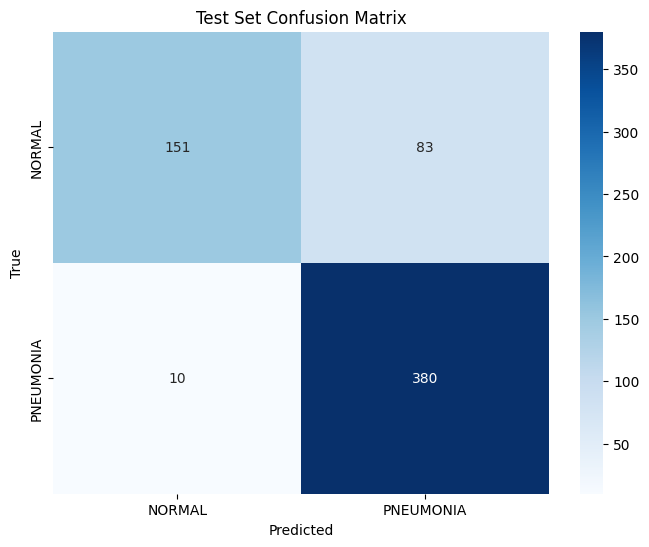


Additional Test Metrics:
Precision: 0.8207
Recall: 0.9744
F1 Score: 0.8910
AUC-ROC: 0.8098


In [22]:
# Evaluate the model on test set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Check if MPS (Apple Silicon GPU) is available
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# Load the saved model (using the original PneumoniaCNN class)
model.load_state_dict(torch.load('pneumonia_cnn_model.pth', map_location=device))
model = model.to(device)
model.eval()

test_preds = []
test_labels = []

# Create a test loader with num_workers=0 to avoid multiprocessing issues
test_loader_no_mp = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=0  # Set to 0 to avoid multiprocessing issues with custom dataset
)

with torch.no_grad():
    for inputs, labels in test_loader_no_mp:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.sigmoid(outputs) > 0.97        
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate metrics for test set
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['NORMAL', 'PNEUMONIA']))

# Plot confusion matrix for test set
test_cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

# Calculate and print additional metrics
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_preds)

print(f"\nAdditional Test Metrics:")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC-ROC: {test_auc:.4f}")
